<a href="https://colab.research.google.com/github/Gestu-ai/Machine-Learning/blob/master/Random Forest/Random Forest Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classifier 

Random forests are known as ensemble learning methods used for classification and regression. Random forests are essentially a collection of decision trees that are each fit on a subsample of the data. While an individual tree is typically noisey and subject to high variance, random forests average many different trees, which in turn reduces the variability and leave us with a powerful classifier.

Random forests are also non-parametric and require little to no parameter tuning. They differ from many common machine learning models used today that are typically optimized using gradient descent. Models like linear regression, support vector machines, neural networks, etc. require a lot of matrix based operations, while tree based models like random forest are constructed with basic arithmetic. In other words, to build a tree all we're really doing is selecting a hand full of observations from out dataset, picking a few features to look through, and finding the value that makes the best split in our data.

**How does the algorithm work?**



*   Select random samples from a given dataset.

*   Construct a decision tree for each sample and get a prediction result from each decision tree.

*   Perform a vote for each predicted result.

*   Select the prediction result with the most votes as the final prediction.

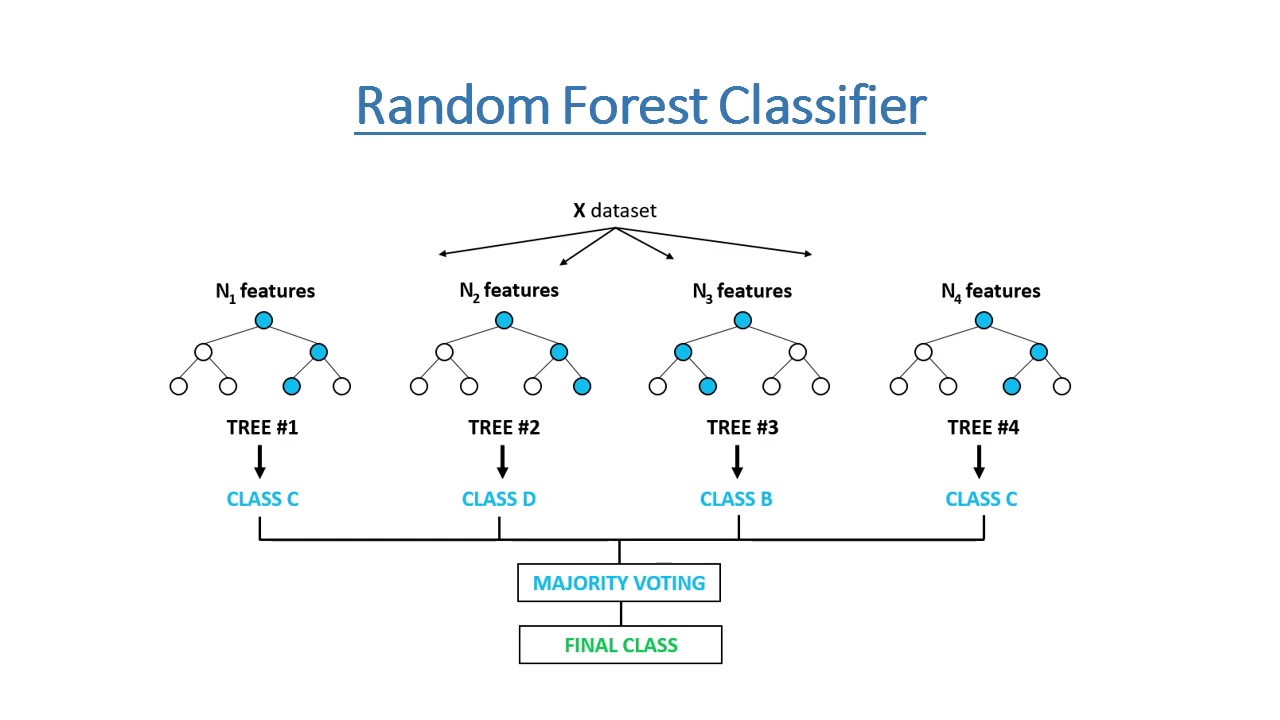







**source:** https://www.researchgate.net/figure/Random-forest-classifier_fig2_341645610

In the flowing code, we develop a Random Forest classifier Algorithm on Sonar Dataset Reference: How to Implement Random Forest From Scratch in Python

# Complete code 

In [ ]:
import urllib.request as urllib2
import copy
from random import seed
from random import randrange
from math import sqrt

Get Sonar data set and preprocess it
    

In [ ]:
def load_data():
    data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
    rows = []
    for line in urllib2.urlopen(data_url).readlines():
        line = line.strip().decode().split(',')
        features = [float(i) for i in line[:-1]]
        label = [1 if line[-1] == 'M' else 0]
        rows.append(features + label)
    return rows

# **1.  Select random samples from a given dataset.**

Simple random sampling with replacement

In [ ]:
def subsample(dataset, ratio):
    sample = []
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

In [ ]:
def test_split(dataset, index, value):
    '''
    split a dataset based on an attribute and an attribute value
    '''
    left  = []
    right = []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

Random forest uses gini importance or mean decrease in impurity (MDI) to calculate the importance of each feature. Gini importance is also known as the total decrease in node impurity. This is how much the model fit or accuracy decreases when you drop a variable. The larger the decrease, the more significant the variable is. Here, the mean decrease is a significant parameter for variable selection. The Gini index can describe the overall explanatory power of the variables.

In [ ]:
def gini_index(groups, class_values):
    '''
    calculate the Gini index for a split dataset
    '''
    gini = 0.0
    for class_value in class_values:
        for group in groups:
            size = len(group)
            if size == 0:
                continue
            proportion = [row[-1] for row in group].count(class_value) / float(size)
            gini += (proportion * (1.0 - proportion))
    return gini

In [ ]:
def get_split(dataset, n_features):
    '''
    select the best split point for a dataset
    '''
    # randomly selected n features
    features = []
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)

    # get set of uniq labels
    class_values = list(set(row[-1] for row in dataset))

    # init params
    b_score  = 9999  # minimum Gini index
    b_index  = None  # index of best column
    b_value  = None  # best cut-off value of the best column
    b_groups = None  # best groups

    # loop through selected features to get the minimum Gini index
    for col_index in features:
        for row in dataset:
            col_value = row[col_index]
            groups = test_split(dataset, col_index, col_value)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index  = col_index
                b_value  = col_value
                b_score  = gini
                b_groups = groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

Return the label with highest frequency
  

In [ ]:
def to_terminal(group):
    
    labels = [row[-1] for row in group]
    return max(set(labels), key=labels.count)

 Create child splits for a node or make terminal


In [ ]:
def split(node, max_depth, min_size, n_features, depth):
   
    left, right = node['groups']
    del(node['groups'])

    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return

    # check for max depth
    if depth >= max_depth:
        node['left']  = to_terminal(left)
        node['right'] = to_terminal(right)
        return

    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)

    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)

# **2.   Construct a decision tree for each sample and get a prediction result from each decision tree.**




In [ ]:

def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root

Make a prediction with a decision tree


In [ ]:
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# **3. Perform a vote for each predicted result.**

In [ ]:
def bagging_predict(trees, row):
    '''
    make a prediction with a list of bagged trees
    '''
    predictions = [predict(tree, row) for tree in trees]
    # return the label that is voted by most of the trees
    return max(set(predictions), key=predictions.count)

# **4. Select the prediction result with the most votes as the final prediction.**

In [ ]:
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    # train
    trees = []
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(tree)
    # predict
    predictions = [bagging_predict(trees, row) for row in test]
    return(predictions)

In [ ]:
def cross_validation_split(dataset, n_folds):
    '''
    split the dataset into n folds
    '''
    dataset_copy = copy.copy(dataset)
    fold_size = int(len(dataset_copy)/n_folds)
    folds = []
    for i in range(n_folds):
        fold = []
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        folds.append(fold)
    return folds

In [ ]:

def accuracy_metric(actual, predicted):
    '''
    calculate accuracy percentage
    '''
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:

def evaluate_algorithm(dataset, algorithm, params, n_folds=5):
    folds = cross_validation_split(dataset, n_folds)
    scores = []
    for fold in folds:
        # prepare train set
        trainset = copy.copy(folds)
        trainset.remove(fold)
        trainset = sum(trainset, []) # flatten trainset
        # prepare test set
        testset = copy.copy(fold)
        # train & predict
        predicted = algorithm(trainset, testset, **params)
        # evaluate
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores


In [ ]:
if __name__ == '__main__':
    seed(1)
    dataset = load_data()
    n_features = int(sqrt(len(dataset[0])-1))
    params = {
        'n_trees': 10                # number of trees to be built
        ,'sample_size': 1.0          # fraction to be randomly sampled for each tree
        ,'n_features':  n_features   # number of features to be randomly selected to evaluate for each split
        ,'max_depth': 10             # maximum depth of each tree
        ,'min_size': 1               # minimum records number after split
    }
    for n_trees in [1, 5, 10, 20]:
        params['n_trees'] = n_trees
        scores = evaluate_algorithm(dataset, random_forest, params, n_folds=5)
        print('Trees: %d' % n_trees)
        print('Scores: %s' % scores)
        print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Trees: 1
Scores: [51.21951219512195, 78.04878048780488, 58.536585365853654, 65.85365853658537, 53.65853658536586]
Mean Accuracy: 61.463%
Trees: 5
Scores: [63.41463414634146, 60.97560975609756, 56.09756097560976, 60.97560975609756, 56.09756097560976]
Mean Accuracy: 59.512%
Trees: 10
Scores: [65.85365853658537, 58.536585365853654, 68.29268292682927, 53.65853658536586, 75.60975609756098]
Mean Accuracy: 64.390%
Trees: 20
Scores: [68.29268292682927, 56.09756097560976, 68.29268292682927, 68.29268292682927, 68.29268292682927]
Mean Accuracy: 65.854%
